# Notebook for RAG on OpenROAD
- Notebook uses Github data sources only. 
- https://huggingface.co/spaces/mteb/leaderboard

## Structure
- Get text
- Chunk text
- Embed text
- Retrieve text

## TODO
- https://stackoverflow.com/questions/10993612/how-to-remove-xa0-from-string-in-python
- Don't use the default retrieval tool in Langchain (Langchain uses 3 LLM calls, more than what is needed. It underneath runs some summarisation. If we dont need this, write your own pipeline.)
- Save the score from db.similarity_search somewhere!

## Ideas
- RAG With agents
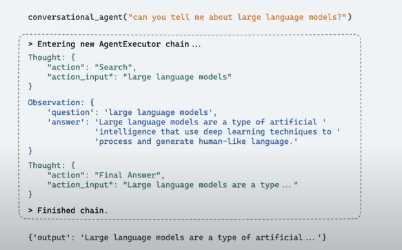
- Conversational Memory
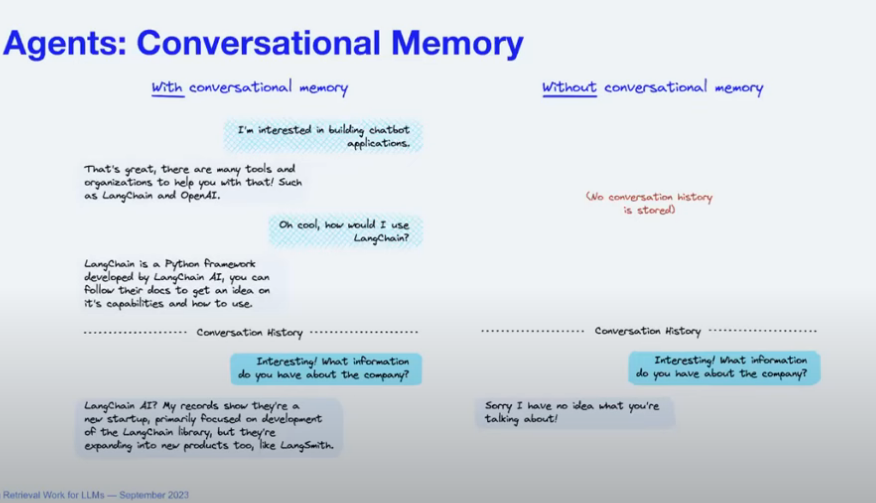

- RAG With guardrails: idea is to classify into the type of categories the user is asking -> then use specific model. Takes more resources for sure. 
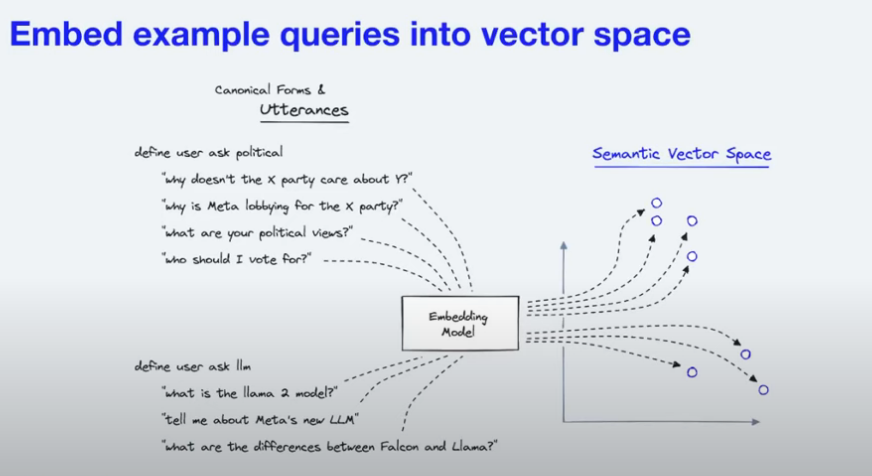

## Main

In [1]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain.schema import Document
import json
from typing import Iterable

In [2]:
def load_docs_from_jsonl(file_path)->Iterable[Document]:
    array = []
    with open(file_path, 'r') as jsonl_file:
        for line in jsonl_file:
            data = json.loads(line)
            obj = Document(**data)
            array.append(obj)
    return array

In [3]:
%%time
# Step 1: Load the document(s) and split it into chunks
chunks = load_docs_from_jsonl('tempdata/data.jsonl')

# Step 2: Create embeddings

# doesn't work too well. 
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
# model_name = "hkunlp/instructor-large"
# model_kwargs = {'device': 'cpu'}
# encode_kwargs = {'normalize_embeddings': False}
# embedding_model = HuggingFaceEmbeddings(
#                 model_name=model_name,
#                 model_kwargs=model_kwargs,
#                 encode_kwargs=encode_kwargs
#                 )

chunks2 = [x.page_content for x in chunks] # HFEmbeddings only accepts str
embeddings = embedding_model.embed_documents(chunks2)

# Step 3: Store embeddings in ChromaDB and save locally.

## IF REGENERATING DB: ##
!rm -rf chroma_db
db = Chroma.from_documents(chunks, embedding_model, persist_directory="./chroma_db")

## IF LOADING DB ##
# db = Chroma(persist_directory="./chroma_db", embedding_function=embedding_model)

# Step 4: Create a retriever
retriever = db.as_retriever()

/home/jack/.cache/pypoetry/virtualenvs/openroad-assistant-BiE8-jDm-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:659: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


Using Maximum Sequence Length:  256


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


CPU times: user 1min 7s, sys: 4.46 s, total: 1min 12s
Wall time: 13.6 s


In [5]:
# PROMPT_TEMPLATE = """<s>[INST] You are now an expert in OpenROAD EDA software. Here is an excerpt of code or documentation you may refer to:
#     {context}[/INST]
#     I am ready. Bring it on!</s>
#     [INST]{question}[/INST]"""
MISTRAL_START= "<s>[INST] "
MISTRAL_END=" [/INST]"
TRIPLE_QUOTES = """\n\"\"\"\n"""
PRE_PROMPT_QUERY = "Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.\n"
PROMPT_QUERY = "\nAccording to only the information in the document sources provided within the context above, "

PROMPT_TEMPLATE = """%s%s{context}%s%s{question}"""%(TRIPLE_QUOTES, PRE_PROMPT_QUERY, TRIPLE_QUOTES, PROMPT_QUERY)
print(PROMPT_TEMPLATE)


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
{context}
"""

According to only the information in the document sources provided within the context above, {question}


In [6]:
from llama_cpp import Llama

def create_completion(question):
    # Step 5: Define the prompt template
    # source: https://chat.openai.com/share/c85e64f6-4dd2-4920-b82e-78f128898cbb
    template = PROMPT_TEMPLATE
    prompt = ChatPromptTemplate.from_template(template)
    
    # Step 6: Generate a query and search for relevant chunks
    context = "\n---\n".join(x[0].page_content for x in db.similarity_search_with_score(question, k = 8))
    final_prompt = prompt.format_messages(context = context, question = question)[0].content
    print(final_prompt)
    
    # Step 7: Use llama-cpp-python as a prototype. 
    llm = Llama(model_path="../llama.cpp/models/mistral-instruct/ggml-model-q4_0.gguf", n_ctx=8000)
    output = llm.create_completion(final_prompt,
                                   suffix=None,
                                   max_tokens=200, # set this to 0 for no limit on tokens (depend on n_ctx)
                                   temperature=0.2, # higher temperature, less factual.
                                   top_p=0.95,
                                   logprobs=None,
                                   echo=False,
                                   stop=[],
                                   frequency_penalty=0.0,
                                   presence_penalty=0.0,
                                   repeat_penalty=1.1,
                                   top_k=40,
                                   stream=False,
                                   tfs_z=1.0,
                                   mirostat_mode=0,
                                   mirostat_tau=5.0,
                                   mirostat_eta=0.1,
                                   model=None,
                                   stopping_criteria=None,
                                   logits_processor=None)
    return context, output
question = "What function does the OpenROAD module name odb serve?"
context, output = create_completion(question)
print(context)
print(output["choices"][0]["text"])


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
OpenROAD project.  
The structure of OpenDB is based on the text file formats LEF
(library) and DEF (design) formats version 5.6.  OpenDB supports a
binary file format to save and load the design much faster than using
LEF and DEF.
---
with the `write_db` command. OpenROAD can then read the database with the
`read_db` command without reading LEF/DEF or Verilog.  
The `read_lef` and `read_def` commands can be used to build an OpenDB database
---
| `src/OpenROAD.tcl` | basic read/write lef/def/db commands |
| `include/ord/OpenROAD.hh` | OpenROAD top-level class, has instances of tools |  
Some tools such as OpenSTA are submodules, which are simply
---
OpenDB is a design database to support tools for physical chip design. It
was originally developed by Athena Design Systems. Nefelus, Inc. acquired
the rights to the code and open-sourced it with BSD-3 license 

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from ../llama.cpp/models/mistral-instruct/ggml-model-q4_0.gguf (version GGUF V3 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q4_0     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q4_0     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q4_0     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q4_0     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.ffn_up.weight q4_0     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    7:            blk.0.ffn_down.weight q4_0     

OpenROAD project.  
The structure of OpenDB is based on the text file formats LEF
(library) and DEF (design) formats version 5.6.  OpenDB supports a
binary file format to save and load the design much faster than using
LEF and DEF.
---
with the `write_db` command. OpenROAD can then read the database with the
`read_db` command without reading LEF/DEF or Verilog.  
The `read_lef` and `read_def` commands can be used to build an OpenDB database
---
| `src/OpenROAD.tcl` | basic read/write lef/def/db commands |
| `include/ord/OpenROAD.hh` | OpenROAD top-level class, has instances of tools |  
Some tools such as OpenSTA are submodules, which are simply
---
OpenDB is a design database to support tools for physical chip design. It
was originally developed by Athena Design Systems. Nefelus, Inc. acquired
the rights to the code and open-sourced it with BSD-3 license in 2019 to support the DARPA
---
Tool namespaces are usually three-lettered lowercase letters.  
- Verilog to DB ([dbSTA](../main/sr


llama_print_timings:        load time =   27531.25 ms
llama_print_timings:      sample time =      12.41 ms /    69 runs   (    0.18 ms per token,  5560.03 tokens per second)
llama_print_timings: prompt eval time =   31359.90 ms /   579 tokens (   54.16 ms per token,    18.46 tokens per second)
llama_print_timings:        eval time =    5225.28 ms /    68 runs   (   76.84 ms per token,    13.01 tokens per second)
llama_print_timings:       total time =   36745.82 ms


## List of benchmark questions
1. What does the short form [INSERT TOOL NAME] stand for?
- Repeat for all the tools
- dbSTA removed because there is no readme for it.

In [7]:
tools = ['odb', 'par', 'pad',
         'pdn', 'tap', 'mpl2', 'gpl',
         'rsz', 'dpl', 'cts', 'grt',
         'ant', 'drt', 'fin', 'dft',
         'rcx', 'sta', 'gui', 'psm']
final_contexts, final_answers = [], []
for tool in tools:
    question = f"What function does the OpenROAD module name {tool} serve?"
    context, answer = create_completion(question)
    answer = answer["choices"][0]["text"]
    final_contexts.append(context)
    final_answers.append(answer)


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
OpenROAD project.  
The structure of OpenDB is based on the text file formats LEF
(library) and DEF (design) formats version 5.6.  OpenDB supports a
binary file format to save and load the design much faster than using
LEF and DEF.
---
with the `write_db` command. OpenROAD can then read the database with the
`read_db` command without reading LEF/DEF or Verilog.  
The `read_lef` and `read_def` commands can be used to build an OpenDB database
---
| `src/OpenROAD.tcl` | basic read/write lef/def/db commands |
| `include/ord/OpenROAD.hh` | OpenROAD top-level class, has instances of tools |  
Some tools such as OpenSTA are submodules, which are simply
---
OpenDB is a design database to support tools for physical chip design. It
was originally developed by Athena Design Systems. Nefelus, Inc. acquired
the rights to the code and open-sourced it with BSD-3 license 

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from ../llama.cpp/models/mistral-instruct/ggml-model-q4_0.gguf (version GGUF V3 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q4_0     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q4_0     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q4_0     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q4_0     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.ffn_up.weight q4_0     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    7:            blk.0.ffn_down.weight q4_0     


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
OpenROAD uses [spdlog]( as part
of logging infrastructure in order to ensure a clear, consistent
messaging and complete messaging interface. A wrapper formats the prefix
in the recommended messaging style and limit. A message format is as
follows:
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
If you cannot find your question/answer here, please file a GitHub issue to
the appropriate repository or start a discussion.  
-   Issues and bugs:
-   OpenROAD: <
-   Discussions:
-   OpenROAD: <
---
Seeing OpenROAD warnings or errors you do not understand? We have compiled a table of all messages
and you may potentially find your answer [here](
---
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical 

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   24127.46 ms
llama_print_timings:      sample time =       4.25 ms /    24 runs   (    0.18 ms per token,  5640.42 tokens per second)
llama_print_timings: prompt eval time =   24127.11 ms /   443 tokens (   54.46 ms per token,    18.36 tokens per second)
llama_print_timings:        eval time =    1869.21 ms /    23 runs   (   81.27 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
The chip-level connections module in OpenROAD (`pad`) is based on the
open-source tool ICeWall. In this utility, either place an IO ring around the
boundary of the chip and connect with either wirebond pads or a bump array.
---
OpenROAD uses [spdlog]( as part
of logging infrastructure in order to ensure a clear, consistent
messaging and complete messaging interface. A wrapper formats the prefix
in the recommended messaging style and limit. A message format is as
follows:
---
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
If you cannot find your question/answer here, please file a GitHub issue to
the appropriate repository or start a discussion.  
-   Issues and bugs:
-   OpenROAD: <
-   Discus

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   26921.22 ms
llama_print_timings:      sample time =       9.01 ms /    51 runs   (    0.18 ms per token,  5661.63 tokens per second)
llama_print_timings: prompt eval time =   27776.75 ms /   528 tokens (   52.61 ms per token,    19.01 tokens per second)
llama_print_timings:        eval time =    3752.47 ms /    50 runs   (   75.05 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
These PDKS are supported in OpenROAD-flow-scripts only. They are used to
test and calibrate OpenROAD against commercial platforms and ensure good
QoR. The PDKs and platform-specific files for these kits cannot be
---
OpenROAD uses [spdlog]( as part
of logging infrastructure in order to ensure a clear, consistent
messaging and complete messaging interface. A wrapper formats the prefix
in the recommended messaging style and limit. A message format is as
follows:
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
The OpenROAD application is PDK independent. However, it has been tested
and validated with specific PDKs in the context of various flow
controllers.  
OpenLane supports SkyWater 130nm and GlobalFoundries 180nm.
---
the command

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   27387.34 ms
llama_print_timings:      sample time =       4.37 ms /    25 runs   (    0.17 ms per token,  5722.13 tokens per second)
llama_print_timings: prompt eval time =   27879.64 ms /   521 tokens (   53.51 ms per token,    18.69 tokens per second)
llama_print_timings:        eval time =    1814.46 ms /    24 runs   (   75.60 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
The chip-level connections module in OpenROAD (`pad`) is based on the
open-source tool ICeWall. In this utility, either place an IO ring around the
boundary of the chip and connect with either wirebond pads or a bump array.
---
The patch file "AddTool.patch" illustrates how to add a tool to
OpenROAD. Use the following commands to add a sample tool:  
This adds a directory `OpenRoad/src/tool` that
illustrates a tool named "Tool" that uses the file structure de

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   27215.72 ms
llama_print_timings:      sample time =      13.92 ms /    74 runs   (    0.19 ms per token,  5317.24 tokens per second)
llama_print_timings: prompt eval time =   28111.94 ms /   527 tokens (   53.34 ms per token,    18.75 tokens per second)
llama_print_timings:        eval time =    6211.88 ms /    73 runs   (   85.09 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purpose |
---
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
The macro placement module in OpenROAD (`mpl`) is based on


..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   27039.82 ms
llama_print_timings:      sample time =      12.48 ms /    65 runs   (    0.19 ms per token,  5206.66 tokens per second)
llama_print_timings: prompt eval time =   28780.76 ms /   541 tokens (   53.20 ms per token,    18.80 tokens per second)
llama_print_timings:        eval time =    5847.44 ms /    64 runs   (   91.37 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
The OpenROAD Project has two releases:  
- Application ([github]( ([docs](main/README.md)): The application is a standalone binary for digital place and route that can be used by any other RTL-GDSII flow controller.
---
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purpose |
---
Courtesy of

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   26852.25 ms
llama_print_timings:      sample time =       3.90 ms /    22 runs   (    0.18 ms per token,  5638.13 tokens per second)
llama_print_timings: prompt eval time =   27189.73 ms /   518 tokens (   52.49 ms per token,    19.05 tokens per second)
llama_print_timings:        eval time =    1533.66 ms /    21 runs   (   73.03 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purpose |
---
OpenROAD uses [spdlog]( as part
of logging infrastructure in order to ensure a clear, consistent
messaging and complete messaging interface. A wrapper formats the prefix
in the recommended messaging style and limit. A message format is as
follows:
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
OpenROAD is a tool t

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   27172.14 ms
llama_print_timings:      sample time =       4.15 ms /    23 runs   (    0.18 ms per token,  5539.50 tokens per second)
llama_print_timings: prompt eval time =   28101.35 ms /   529 tokens (   53.12 ms per token,    18.82 tokens per second)
llama_print_timings:        eval time =    1725.45 ms /    22 runs   (   78.43 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
The detailed placement module in OpenROAD (`dpl`) is based on OpenDP, or
Open-Source Detailed Placement Engine. Its key features are:  
-   Fence region.
-   Fragmented ROWs.
---
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purpose |
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
The Detailed Routing (`drt`) module in OpenROAD is based on the open-sou

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   27358.23 ms
llama_print_timings:      sample time =       8.78 ms /    46 runs   (    0.19 ms per token,  5239.18 tokens per second)
llama_print_timings: prompt eval time =   27357.72 ms /   510 tokens (   53.64 ms per token,    18.64 tokens per second)
llama_print_timings:        eval time =    3510.02 ms /    45 runs   (   78.00 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
The clock tree synthesis module in OpenROAD (`cts`) is based on TritonCTS
2.0. It is available from the `clock_tree_synthesis` command. TritonCTS 2.0
performs on-the-fly characterization. Thus, there is no need to generate
---
If you cannot find your question/answer here, please file a GitHub issue to
the appropriate repository or start a discussion.  
-   Issues and bugs:
-   OpenROAD: <
-   Discussions:
-   OpenROAD: <
---
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
global variable in `openroad` shou

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   25177.55 ms
llama_print_timings:      sample time =      11.45 ms /    58 runs   (    0.20 ms per token,  5063.73 tokens per second)
llama_print_timings: prompt eval time =   25177.05 ms /   477 tokens (   52.78 ms per token,    18.95 tokens per second)
llama_print_timings:        eval time =    5815.41 ms /    57 runs   (  102.02 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purpose |
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
If you cannot find your question/answer here, please file a GitHub issue to
the appropriate repository or start a discussion.  
-   Issues and bugs:
-   OpenROAD: <
-   Discussions:
-   OpenROAD: <
---
the bottom of the tool dependencies. Each `init` function grabs the state
it needs out of the `OpenRoad` instance.
---
The patch file "AddTool.patch" illustrates how to add a tool to
OpenROAD. Use the following commands to add a sample tool:  
This adds a direct

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   24190.27 ms
llama_print_timings:      sample time =       7.52 ms /    41 runs   (    0.18 ms per token,  5453.58 tokens per second)
llama_print_timings: prompt eval time =   24189.80 ms /   459 tokens (   52.70 ms per token,    18.97 tokens per second)
llama_print_timings:        eval time =    2955.47 ms /    40 runs   (   73.89 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
If you cannot find your question/answer here, please file a GitHub issue to
the appropriate repository or start a discussion.  
-   Issues and bugs:
-   OpenROAD: <
-   Discussions:
-   OpenROAD: <
---
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
OpenROAD uses [spdlog]( as part
of logging infrastructure in order to ensure a clear, consistent
messaging and complete messaging interface. A wrapper formats the prefix
in the recommended messaging style and limit. A message format is as
follows:
---
This folder contains the top-level files for overa

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   27139.55 ms
llama_print_timings:      sample time =       4.36 ms /    24 runs   (    0.18 ms per token,  5504.59 tokens per second)
llama_print_timings: prompt eval time =   28329.70 ms /   534 tokens (   53.05 ms per token,    18.85 tokens per second)
llama_print_timings:        eval time =    1643.10 ms /    23 runs   (   71.44 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
The Detailed Routing (`drt`) module in OpenROAD is based on the open-source
detailed router, TritonRoute. TritonRoute consists of several main
building blocks, including pin access analysis, track assignment,
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
If you cannot find your question/answer here, please file a GitHub issue to
the appropriate repository or start a discussion.  
-   Issues and bugs:
-   OpenROAD: <
-   Discussions:
-   OpenROAD: <
---
This folder contains the top-level files for overall compilation. Op

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   26820.94 ms
llama_print_timings:      sample time =      11.20 ms /    55 runs   (    0.20 ms per token,  4909.40 tokens per second)
llama_print_timings: prompt eval time =   28192.13 ms /   538 tokens (   52.40 ms per token,    19.08 tokens per second)
llama_print_timings:        eval time =    5197.98 ms /    54 runs   (   96.26 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purpose |
---
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
The chip-level connections module in OpenROAD (`pad`) is ba

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
llama_new_context_with_model: compute buffer total size = 546.25 MB

llama_print_timings:        load time =   26366.43 ms
llama_print_timings:      sample time =      11.38 ms /    61 runs   (    0.19 ms per token,  5358.40 tokens per second)
llama_print_timings: prompt eval time =   26365.82 ms /   500 tokens (   52.73 ms per token,    18.96 tokens per second)
llama_print_timings:        eval time =    4707.50 ms /    60 runs   (   78.46 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
OpenROAD uses [spdlog]( as part
of logging infrastructure in order to ensure a clear, consistent
messaging and complete messaging interface. A wrapper formats the prefix
in the recommended messaging style and limit. A message format is as
follows:
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
The Detailed Routing (`drt`) module in OpenROAD is based on the open-source
detailed router, TritonRoute. TritonRoute consists of several main
building blocks, including pin access analysis, track assignment,
---
The OpenROAD Proje

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
llama_new_context_with_model: compute buffer total size = 546.25 MB

llama_print_timings:        load time =   28468.38 ms
llama_print_timings:      sample time =       0.19 ms /     1 runs   (    0.19 ms per token,  5235.60 tokens per second)
llama_print_timings: prompt eval time =   28467.92 ms /   512 tokens (   55.60 ms per token,    17.99 tokens per second)
llama_print_timings:        eval time =      85.81 ms /     1 runs   (   85.81 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
This flow generates the RC tech file for OpenRCX. The RC tech file provides
resistance and capacitance tables used for RC extraction for a specific process
corner.
---
The parasitics extraction module in OpenROAD (`rcx`) is based on the
open-source OpenRCX, a Parasitic Extraction (PEX, or RCX) tool that
works on OpenDB design APIs.
It extracts routed designs based on the LEF/DEF layout model.
---
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purpose |
---
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
This flow generates an Extraction Rules file

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   24682.22 ms
llama_print_timings:      sample time =      19.37 ms /   100 runs   (    0.19 ms per token,  5162.36 tokens per second)
llama_print_timings: prompt eval time =   24681.79 ms /   470 tokens (   52.51 ms per token,    19.04 tokens per second)
llama_print_timings:        eval time =    9101.38 ms /    99 runs   (   91.93 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purpose |
---
OpenROAD is a tool to build a chip from synthesizable RTL (Verilog) to
completed physical layout (manufacturable, tapeout-clean GDSII).  
The unifying principle behind the design of OpenROAD is for all of the
---
Courtesy of [Precision Innovations]( there are pre-built binaries
of OpenROAD with self-contained dependencies released on a regular basis.
Refer to this [link]( here.
---
OpenROAD uses [spdlog]( as part
of logging infrastructure in order to ensure a clear, consistent
messaging and complete messaging interface. A wrapper formats the prefix
in the recommended messaging style and limit. A message format is as
follows:
---

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   25910.05 ms
llama_print_timings:      sample time =       4.19 ms /    24 runs   (    0.17 ms per token,  5732.03 tokens per second)
llama_print_timings: prompt eval time =   25909.60 ms /   493 tokens (   52.55 ms per token,    19.03 tokens per second)
llama_print_timings:        eval time =    1646.39 ms /    23 runs   (   71.58 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
The graphical user interface can be access by launching OpenROAD with ``-gui`` or by opening it from the command-line with ``gui::show``.
---
The OpenROAD GUI is a powerful visualization, analysis, and debugging
tool with a customizable Tcl interface. The below figures show GUI views for
various flow stages including floorplanning, placement congestion,
CTS and post-routed design.
---
If you cannot find your question/answer here, please file a GitHub issue to
the appropriate repository or start a discussion.  
-   Issues and bugs:
-   OpenROAD: <
-   Discussions:
-   OpenROAD: <
---
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   24137.12 ms
llama_print_timings:      sample time =       6.54 ms /    33 runs   (    0.20 ms per token,  5043.56 tokens per second)
llama_print_timings: prompt eval time =   24136.70 ms /   454 tokens (   53.16 ms per token,    18.81 tokens per second)
llama_print_timings:        eval time =    3439.59 ms /    32 runs   (  107.49 ms per tok


"""
Pay attention and remember the information below, which will help to answer the question or imperative after the context ends.
OpenROAD uses [spdlog]( as part
of logging infrastructure in order to ensure a clear, consistent
messaging and complete messaging interface. A wrapper formats the prefix
in the recommended messaging style and limit. A message format is as
follows:
---
If you cannot find your question/answer here, please file a GitHub issue to
the appropriate repository or start a discussion.  
-   Issues and bugs:
-   OpenROAD: <
-   Discussions:
-   OpenROAD: <
---
the command line. Unless the `-exit` command line flag is specified, it
enters an interactive Tcl command interpreter.  
A list of the available tools/modules included in the OpenROAD app
---
This folder contains the top-level files for overall compilation. OpenROAD uses [swig]( that acts as a wrapper for C/C++ programs to be callable in higher-level languages, such as Python and Tcl.  
| `OpenROAD`      | Purp

..................................................................................................
llama_new_context_with_model: n_ctx      = 8000
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  = 1000.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 546.25 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 

llama_print_timings:        load time =   25486.96 ms
llama_print_timings:      sample time =       4.36 ms /    24 runs   (    0.18 ms per token,  5502.06 tokens per second)
llama_print_timings: prompt eval time =   25486.50 ms /   485 tokens (   52.55 ms per token,    19.03 tokens per second)
llama_print_timings:        eval time =    1729.80 ms /    23 runs   (   75.21 ms per tok

In [8]:
# create dataset [question, context, answer, ground-truths]
import pandas as pd

df = pd.read_csv('evaluation/or.csv')
df["answer"] = final_answers
df["contexts"] = final_contexts
df = df.filter(["question", "contexts", "answer", "ground_truths"])
df

,question,contexts,answer,ground_truths
0,What does the odb module in OpenROAD stand for?,OpenROAD project. \nThe structure of OpenDB i...,\n\r\nAnswer: The OpenROAD module name odb se...,OpenDB Open Database
1,What does the par module in OpenROAD stand for?,OpenROAD uses [spdlog]( as part\nof logging in...,\n\r\nThe function served by the OpenROAD mod...,TritonPart: constraints-driven partitioner
2,What does the pad module in OpenROAD stand for?,The chip-level connections module in OpenROAD ...,\n\r\nThe OpenROAD module name pad serves as ...,Chip-level connections module based on ICeWall
3,What does the pdn module in OpenROAD stand for?,These PDKS are supported in OpenROAD-flow-scri...,\n\r\nThe function of the OpenROAD module nam...,Power distribution network generation
4,What does the tap module in OpenROAD stand for?,the command line. Unless the `-exit` command l...,\n\r\nThe OpenROAD module named `tap` serves ...,Tapcell and welltie insertion
5,What does the mpl2 module in OpenROAD stand for?,This folder contains the top-level files for o...,\n\r\nThe macro placement module in OpenROAD ...,Hierarchical automatic macro placer
6,What does the gpl module in OpenROAD stand for?,OpenROAD is a tool to build a chip from synthe...,\n\r\nThe information provided does not menti...,RePlAce Global Placer
7,What does the rsz module in OpenROAD stand for?,the command line. Unless the `-exit` command l...,"\n\r\nThe OpenROAD module name ""rsz"" is not m...",Gate resizing and buffering
8,What does the dpl module in OpenROAD stand for?,The detailed placement module in OpenROAD (`dp...,\n\r\nThe OpenROAD module named dpl serves as...,Detailed placement
9,What does the cts module in OpenROAD stand for?,the command line. Unless the `-exit` command l...,!\n\r\nThe OpenROAD module name cts serves as ...,Clock Tree synthesis


In [11]:
for i in range(19):
    print("===========================")
    question = f'What does the module name "{tools[i]}" stand for?'
    print(question)
    print("===========")
    print(final_contexts[i])
    print("===========")

    print(df.answer[i])
    print("=============Answer=============")


What does the module name "odb" stand for?
OpenROAD project.  
The structure of OpenDB is based on the text file formats LEF
(library) and DEF (design) formats version 5.6.  OpenDB supports a
binary file format to save and load the design much faster than using
LEF and DEF.
---
with the `write_db` command. OpenROAD can then read the database with the
`read_db` command without reading LEF/DEF or Verilog.  
The `read_lef` and `read_def` commands can be used to build an OpenDB database
---
| `src/OpenROAD.tcl` | basic read/write lef/def/db commands |
| `include/ord/OpenROAD.hh` | OpenROAD top-level class, has instances of tools |  
Some tools such as OpenSTA are submodules, which are simply
---
OpenDB is a design database to support tools for physical chip design. It
was originally developed by Athena Design Systems. Nefelus, Inc. acquired
the rights to the code and open-sourced it with BSD-3 license in 2019 to support the DARPA
---
Tool namespaces are usually three-lettered lowercase let

In [10]:
# import csv
# df.to_csv("evaluation/eval2.csv", index =False, quoting=csv.QUOTE_NONE, quotechar='',escapechar='\\')
df.to_json("evaluation/eval.json", index= False)

## Baseline: No RAG

In [ ]:
from llama_cpp import Llama

def create_no_rag_completion(question):
    # Step 5: Define the prompt template
    # source: https://chat.openai.com/share/c85e64f6-4dd2-4920-b82e-78f128898cbb
    template = PROMPT_TEMPLATE
    prompt = ChatPromptTemplate.from_template(template)
    final_prompt = prompt.format_messages(question = question)[0].content
    
    # Step 7: Use llama-cpp-python as a prototype. 
    llm = Llama(model_path="../llama.cpp/models/mistral-instruct/ggml-model-q4_0.gguf", n_ctx=8000)
    output = llm.create_completion(final_prompt,
                                   suffix=None,
                                   max_tokens=0, # set this to 0 for no limit on tokens (depend on n_ctx)
                                   temperature=0.75, # higher temperature, less factual.
                                   top_p=0.95,
                                   logprobs=None,
                                   echo=True,
                                   stop=[],
                                   frequency_penalty=0.0,
                                   presence_penalty=0.0,
                                   repeat_penalty=1.1,
                                   top_k=40,
                                   stream=False,
                                   tfs_z=1.0,
                                   mirostat_mode=0,
                                   mirostat_tau=5.0,
                                   mirostat_eta=0.1,
                                   model=None,
                                   stopping_criteria=None,
                                   logits_processor=None)
    return output
# create_no_rag_completion(question)

## Run benchmark

In [ ]:
tools = ['par', 'rmp', 'ifp', 'ppl', 'pad']
final2 = []
for tool in tools:
    question = f'What does the short form "{tool.upper()}" stand for?'
    final2.append(create_no_rag_completion(question)["choices"][0]["text"])

In [ ]:
for i in final2:
    print(i)